# Heat equation and numerical methods for image processing

Before diving into advanced machine learning, this notebook will serve as a refresher on partial differential equations (PDEs), with a focus on the heat equation and its implementation.

*Why the heat equation?*
It is one of the most fundamental PDEs in physics, describing how the temperature (or any diffusive quantity) spreads through a medium over time.
This equation governs how particles diffuse and connect to probability theory; the heat kernel is a Gaussian.

You might not expect it, but the heat equation pops up in many ML/CV applications:
- In image processing, it is used for Gaussian blurring.
- In computer vision and graphics, it allows painterly rendering.
- In probabilistic ML, it is tied to Brownian motion and stochastic processes. 


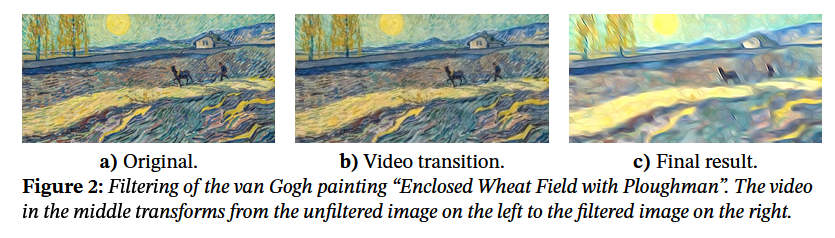

From: https://nils-olovsson.se/articles/image_smearing_by_anisotropic_diffusion/

## The heat equation

The heat equation is a partial differential equation (PDE) that describes how the temperature varies in a given region over time. The general form of the heat equation in 1D is:

$$\frac{\partial f(x,t)}{\partial t} = c \frac{\partial^2 f(x,t)}{\partial x^2}$$

Where:

- $f(x,t)$ is the temperature (or signal) at position $x$ and time $t$.
- $\frac{\partial f(x,t)}{\partial t}$ is the rate of change of temperature with respect to time at position $x$.
- $\frac{\partial^2 f(x,t)}{\partial x^2}$ is the second spatial derivative of the temperature at position $x$, which describes how the slope of the temperature is changing at that point.
- $c$ is the conduction factor, which represents how quickly heat diffuses through the material.

You can think of the second derivative as taking the derivative of a derivative:

$$\frac{\partial^2 f(x,t)}{\partial x^2} = \frac{\partial}{\partial x} \left( \frac{\partial f(x,t)}{\partial x} \right)$$

### Other Famous PDEs

The heat equation is a type of partial differential equation that describes how a quantity, such as temperature, diffuses through a medium over time. Several other important partial differential equations in physics have a similar form or analogous behaviour. Here are a few examples:


**Wave Equation**

![2D Wave Equation Solution](https://upload.wikimedia.org/wikipedia/commons/b/bb/2D_Wave_Function_resize.gif)

*Source: [Wikipedia - 2D Wave Equation](https://en.wikipedia.org/wiki/Wave_equation)*

The wave equation describes the propagation of waves, such as sound, through a medium.
It is given by:

$$\frac{\partial^2 u}{\partial t^2} = c^2 \Delta u$$

Here, $u$ is the displacement of the wave, $c$ is the speed of the wave, and $\Delta$ is the Laplacian operator, which involves second spatial derivatives.


**Advection equation**

![2D Advection Equation Solution](assets/640px-GaussianUpwind2D.gif)

*Source: [Wikipedia - 2D Advection Equation](https://en.wikipedia.org/wiki/Advection)*

Describe the transport of a concentration $c$ through a flow velocity $\mathbf{v}$.

$$\frac{\partial c}{\partial t} + \nabla \cdot (\mathbf{v}c) = 0$$

If the flow is incompressible, the PDE can be rewritten as :

$$\frac{\partial c}{\partial t} + \mathbf{v} \cdot \nabla c = 0$$


**Fokker-Planck Equation**

This equation describes the time evolution of the probability density function of the position and velocity of a particle undergoing diffusion in a potential.
It is used in **statistical mechanics** and has the form:

$$
\frac{\partial}{\partial t} f(x, v, t) = -\frac{\partial}{\partial x} [v f(x, v, t)] + \frac{\partial}{\partial v} [\gamma v f(x, v, t)] + D \frac{\partial^2}{\partial v^2} f(x, v, t)
$$

Here, $f(x,v,t)$ is the probability density function, $\gamma$ is the damping coefficient, and $D$ is the diffusion coefficient.

**Schrödinger Equation**

The time-dependent Schrödinger equation is fundamental in **quantum mechanics** and describes how the quantum state of a physical system changes over time.

$$i\hbar \frac{\partial}{\partial t} \Psi(\mathbf{r}, t) = \hat{H} \Psi(\mathbf{r}, t)$$

Here, $\Psi(r,t)$ is the wave function, $\hat{H}$ is the Hamiltonian operator, $ℏ$ is the reduced Planck constant, and $i$ is the imaginary unit. The Hamiltonian operator often includes a term analogous to the Laplacian (second spatial derivative) in the heat equation, representing kinetic energy.


These equations all involve derivatives with respect to time and space, illustrating how different physical quantities evolve and interact. The Schrödinger equation, in particular, is crucial for understanding quantum mechanical systems and exhibits wave-like solutions similar to those found in the wave equation.

## Discretisation of derivative

To solve the heat equation numerically, we can use finite differences to approximate the function's derivative. 

Given the spatial $\delta_x$ and time $\delta_t$ time discretisation steps, we can define the forward finite difference as:

$$ \frac{\partial f(x,t)}{\partial x} \approx  \frac{f(x+\delta_x,t) - f(x,t)}{\delta_x} := \Delta_{\delta_x} f(x,t) $$

and

$$ \frac{\partial f(x,t)}{\partial t} \approx  \frac{f(x,t+\delta_t) - f(x,t)}{\delta_t} := \Delta_{\delta_t} f(x,t) $$


The second-order derivative can be computed by applying the forward difference twice.

$$ \frac{\partial^2 f(x,t)}{\partial x^2} \approx \frac{\Delta_{\delta_x} f(x,t) - \Delta_{\delta_x} f(x-\delta_x,t)}{\delta_x} $$


$$ \frac{\partial^2 f(x,t)}{\partial x^2} \approx \frac{\frac{f(x+\delta_x,t) - f(x,t)}{\delta_x} - \frac{f(x,t) - f(x -\delta_x,t)}{\delta_x} }{\delta_x} $$

$$ \frac{\partial^2 f(x,t)}{\partial x^2} \approx \frac{f(x+\delta_x,t) - 2f(x,t)+ f(x -\delta_x,t)}{(\delta_x)^2} = \Delta_{\delta_x}^2 f(x,t) $$


## Finite difference: vectorised implementation

In order to validate our implementation, we will consider a simple function $f(x) = \sin(x)$. In this case, the exact derivative is given by:
$$\frac{\partial f(x)}{\partial x} = \cos(x)$$

Write a function `forward_finite_difference` that computes the forward finite difference of a function $f(x)$ at a given point $x$ given the discretisation step $\delta_x$. The function should return the approximated derivative and work for vectorised input.

The input to the function will be the function $f$, evaluated on the vector $x$, the vector $x$ is defined as:
$$
x_i = \text{start} + i \cdot \delta_x
$$
so that the finite difference $\Delta_{\delta_x} f(x,t)$ is computed as:
$$
(\Delta_{\delta_x} f)_{i} = \frac{f_{i+1} - f_{i}}{\delta_x}
$$
Using the above definition and [python array slicing](https://www.w3schools.com/python/numpy/numpy_array_slicing.asp), finish the implementation of the function `forward_finite_difference`.


In [ ]:
import torch

def forward_finite_difference(f, dx):
    discrete_derivative = ...    
    return discrete_derivative

Verify that your implementation is correct by comparing the result with the **true derivative** of the function $f(x) = \sin(x)$. 

In [ ]:
import matplotlib.pyplot as plt


nx = 1000 # Number of discretisation points : tune this value and check how it affects the accuracy

f = torch.sin
true_derivative = torch.cos

start = -torch.pi  
end = torch.pi  

x = torch.linspace(start, end, nx)
dx = x[1] - x[0]


dx_f = forward_finite_difference(f(x), dx)
dx_true = true_derivative(x[:-1])

plt.figure(figsize=(10, 5))
plt.plot(x[:-1].numpy(), dx_f.numpy(), label='Forward Finite Difference', color='blue')
plt.plot(x[:-1].numpy(), dx_true.numpy(), label='True Derivative', color='red', linestyle='--')
plt.title('Forward Finite Difference vs True Derivative')
plt.xlabel('x')


MAE = torch.mean(torch.abs(dx_f - dx_true))

print(f'dx {dx} : Mean Absolute Error (MAE): {MAE}')

Now we can implement the second-order derivative using the forward difference described in the introduction of this Lab. 

Note that it can be computed as:
$$
(\Delta_{\delta_x}^2 f)_{i} = \frac{f_{i-1} - 2f_{i} + f_{i+1}}{\delta_x^2}
$$

Complete the code below for the function `second_order_finite_difference`.

In [ ]:
import torch

def second_order_finite_difference(f, dx):
    discrete_derivative = ...    
    return discrete_derivative


Similarly, verify that your implementation is correct by comparing the result with the **true second derivative** of the function $f(x) = \sin(x)$.

In [ ]:
import matplotlib.pyplot as plt

nx = 50

f = torch.sin
true_derivative = lambda x: -torch.sin(x)

start = -torch.pi  
end = torch.pi  

x = torch.linspace(start, end, nx) 
dx = x[1] - x[0]


dxdx_f = second_order_finite_difference(f(x), dx)
dxdx_true = true_derivative(x[1:-1])


plt.figure(figsize=(10, 5))
plt.plot(x[1:-1].numpy(), dxdx_f.numpy(), label='Second Order Finite Difference', color='blue')
plt.plot(x[1:-1].numpy(), dxdx_true.numpy(), label='True Derivative', color='red', linestyle='--')
plt.title('Second Order Finite Difference vs True Derivative')
plt.xlabel('x')
plt.legend()
plt.show()

MAE = torch.mean(torch.abs(dxdx_f - dxdx_true))

print(f'dx {dx} : Mean Absolute Error (MAE): {MAE}')

## Finite difference: using convolution

Forward difference can also be thought of as a [convolution](https://en.wikipedia.org/wiki/Convolution) with a well-chosen kernel $K$.

Recall that 
$$(f * K)[i] = \sum_{j=-\infty}^\infty f[j] K[i - j]$$

so that the forward difference can be computed by setting 
$$K = [-1.0,1.0] dx^{-1}$$


Complete the function `finite_difference_conv` below. You can use the [doc](https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv1d.html) of `Conv1d` to help you fill the arguments of the `Conv1d` constructor. 

A visualisation of the convolution operation with `stride` and `padding` can be found [here](https://hannibunny.github.io/mlbook/neuralnetworks/convolutionDemos.html).

In [ ]:
def finite_difference_conv(f, dx):
    conv = torch.nn.Conv1d(1, 1, kernel_size=None, stride=None, padding=None, bias=None)    
    K = torch.tensor([...])     
    conv.weight.data = K.clone().view(1, 1, 2)
    f_tensor = f.view(1, 1, -1)
    discrete_derivative = conv(f_tensor)
    discrete_derivative = discrete_derivative.view(-1)
    discrete_derivative /= ...    
    return discrete_derivative

You will validate your implementation by comparing the function output with the one obtained using the `forward_finite_difference` function.

In [ ]:
import torch

nx = 200
f = torch.sin

start = -torch.pi  
end = torch.pi  

x = torch.linspace(start, end, nx) 
dx = x[1] - x[0]    


dx_f_fd = forward_finite_difference(f(x), dx)
dx_f_conv = finite_difference_conv(f(x), dx)

print(f'L2 Error (FD vs Conv): {torch.norm(dx_f_fd - dx_f_conv)}')


As discussed in the introduction, the second-order derivative can be computed by applying the differentiation operation twice. Complete the code below for the function `second_order_finite_difference_conv`.

In [ ]:
import torch

def second_order_finite_difference_conv(f, dx):
    discrete_derivative = ...
    return discrete_derivative

Visually compare the results of the finite difference and convolution methods for the second-order derivative.

In [ ]:

import matplotlib.pyplot as plt

nx = 100

f = torch.sin
true_derivative = lambda x: -torch.sin(x)

start = -torch.pi  
end = torch.pi

x = torch.linspace(start, end, nx)
dx = x[1] - x[0]

dxdx_f_fd = second_order_finite_difference(f(x), dx)
dxdx_f_conv = second_order_finite_difference_conv(f(x), dx)

dxdx_exact = true_derivative(x[1:-1])
plt.figure(figsize=(10, 5))
plt.plot(x[1:-1].numpy(), dxdx_f_fd.numpy(), label='Second Order Finite Difference', color='blue')
plt.plot(x[1:-1].numpy(), dxdx_f_conv.detach().numpy(), label='Second Order Finite Difference Conv', color='green')
plt.plot(x[1:-1].numpy(), dxdx_exact.numpy(), label='True Derivative', color='red', linestyle='--')
plt.title('Second Order Finite Difference vs True Derivative')
plt.xlabel('x')
plt.legend()
plt.show()



However, we can compute directly the second-order derivative kernel $K_2$ by noticing that $K_2 = K * K$

$$ K_2 = [K_0K_0, K_0K_1 + K_1K_0, K_1K_1] dx^{-2} = [1.0,-2.0,1.0] dx^{-2}$$

Using this kernel, complete the code below for the function `second_order_finite_difference_fast`.

In [ ]:
import torch 

def second_order_finite_difference_fast(f, dx):
   conv = torch.nn.Conv1d(1, 1, kernel_size=None, stride=None, padding=None, bias=None)
   K2 = torch.tensor([...])   
   conv.weight.data = K2.clone().view(1, 1, 3)
   f_tensor = f.view(1, 1, -1)
   discrete_derivative = conv(f_tensor)
   discrete_derivative = discrete_derivative.view(-1)
   discrete_derivative /= ...   
   return discrete_derivative


Again, verify that your implementation is correct by comparing your method's results with the true derivative.

In [ ]:
import matplotlib.pyplot as plt

nx = 200

f = torch.sin
true_derivative = lambda x: -torch.sin(x)

start = -torch.pi  
end = torch.pi

x = torch.linspace(start, end, nx)
dx = x[1] - x[0]

dxdx_f_fd = second_order_finite_difference(f(x), dx)
dxdx_f_conv = second_order_finite_difference_fast(f(x), dx)

dxdx_exact = true_derivative(x[1:-1])
plt.figure(figsize=(10, 5))
plt.plot(x[1:-1].numpy(), dxdx_f_fd.numpy(), label='Second Order Finite Difference', color='blue')
plt.plot(x[1:-1].numpy(), dxdx_f_conv.detach().numpy(), label='Second Order Finite Difference with 1 Conv', color='green')
plt.plot(x[1:-1].numpy(), dxdx_exact.numpy(), label='True Derivative', color='red', linestyle='--')
plt.title('Second Order Finite Difference vs True Derivative')
plt.xlabel('x')
plt.legend()
plt.show()


## Profiling

We implemented the second-order finite difference using 3 different methods:
- `second_order_finite_difference` (without convolution, vectorised)
- `second_order_finite_difference_conv` (using 2 1D convolutions, with a kernel of size 2)
- `second_order_finite_difference_fast` (using 1 1D convolution, with a kernel of size 3)

We would like to know which method is the most efficient. This can be done using the `torch.profiler` module.

Using the [torch profiler](https://pytorch.org/docs/stable/profiler.html), and the snippet below, profile your 3 implementations of the second-order finite difference.

```python
N = 100_000
with torch.profiler.profile(activities=[torch.profiler.ProfilerActivity.CPU], record_shapes=True) as prof:
    with torch.profiler.record_function("Profiling softmax"):
 x = torch.randn(1,1,N)
        for _ in range(1000):  # Run multiple times to get a good average
 out = torch.nn.functional.softmax(x, dim=-1)            
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))
```

In [ ]:
N = 100_000
with torch.profiler.profile(activities=[torch.profiler.ProfilerActivity.CPU], record_shapes=True) as prof:
    with torch.profiler.record_function("Measuring complexity of softmax"):
        x = torch.randn(1,1,N)
        for _ in range(1000):  # Run multiple times to get a good average
            out = torch.nn.functional.softmax(x, dim=-1)            
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

In [ ]:
nx = 2000

start = -torch.pi  
end = torch.pi

x = torch.linspace(start, end, nx)
dx = x[1] - x[0]

# finite difference vectorised implementation


In [ ]:
nx = 2000

start = -torch.pi  
end = torch.pi

x = torch.linspace(start, end, nx)
dx = x[1] - x[0]

# 2 conv1D second order finite difference


In [ ]:

nx = 2000

start = -torch.pi  
end = torch.pi

x = torch.linspace(start, end, nx)
dx = x[1] - x[0]

# 1 conv1D second order finite difference


# Simulation of the heat equation

Recall that 
$$\frac{\partial f(x,t)}{\partial t} = c \frac{\partial^2 f(x,t)}{\partial x^2}$$
By first subtituing $\frac{\partial f(x,t)}{\partial t}$ by its forward difference we obtain
$$\frac{f(x,t+\delta_t) - f(x,t)}{\delta_t} = c  \frac{\partial^2 f(x,t)}{\partial x^2}$$
Then multiplying by $\delta_t$ and arranging the terms, we obtain
$$f(x,t+\delta_t) = f(x,t) + \delta_t c \frac{\partial^2 f(x,t)}{\partial x^2}$$

Now write a function `time_forward` that, given the current temperature, computes the updated temperature at time $t + \delta_t$, you will need to use the `second_order_finite_difference` function you created in the previous section.

In [ ]:
def time_forward(f, dt, c, dx):    
    ft_plus = torch.zeros_like(f)
    dxdx_f = second_order_finite_difference(f, dx)
    ft_plus[1:-1] = ...    
    ft_plus[0] = ft_plus[1] 
    ft_plus[-1] = ft_plus[-2]  # Assuming f[-1] = f[-2] for boundary condition
    
    return ft_plus

Given the initial temperature $f(x,0) : [-5,5] \mapsto \mathbb{R}$ :
$$
\begin{cases}
1 &, \quad \text{if} \quad |x| < 1 \\
0 &, \quad \text{if} \quad |x| \geq 1
\end{cases}
$$

Compute the temperature at time $t = 2$ using the `time forward` function you just implemented. You will need to implement the function `initial_condition` which returns the initial temperature $f(x,0)$.

In [ ]:

import matplotlib.pyplot as plt
import torch

def initial_condition(x):
    f_0 = torch.zeros_like(x)
    # Implement the initial temperature here 
    f_0[...] = ...
    return f_0

Nx = 100
c = 1.0
dt = 0.0001 # this need to be small enough (CFL condition)

Start_x = -5
End_x = 5


x = torch.linspace(Start_x, End_x, Nx)
dx = x[1] - x[0]

f_0 = initial_condition(x)




# Plot the initial condition
f = f_0.clone()
plt.plot(x.detach().numpy(), f.detach().numpy(), label='Initial Condition', color='blue')
plt.xlabel('x')
plt.ylabel('f(x, 0)')
plt.title('Initial Condition')
plt.legend()
plt.show()



snapshots = [f.clone()]
times = [0.0]

for i in range(20_000):
    f = time_forward(f, dt, c, dx)
    snapshots.append(f.clone())
    times.append((i+1) * dt)    

Use the following snippet to visualise your result.

In [ ]:
import ipywidgets as widgets
from IPython.display import display

slider = widgets.IntSlider(value=0, min=0, max=len(snapshots) - 1, step=1, description='Step')
def update_plot(step):
    plt.figure(figsize=(8, 5))
    plt.plot(x.detach().numpy(), snapshots[step].detach().numpy(), color='blue')
    plt.xlabel('x')
    plt.ylabel('f(x, t)')
    plt.title(f't = {times[step]:.4f}')
    plt.xlim(Start_x, End_x)
    plt.ylim(-0.1, 1.1)
    plt.grid(True)
    plt.show()

widgets.interact(update_plot, step=slider);

### Interpretation of the terms

Let's interpret the derivative terms of the heat equation in order to grasp the physical meaning of the equation. To do so, we will use an analogy to the microscopic view of the [Fick's laws of diffusion](https://en.wikipedia.org/wiki/Fick%27s_laws_of_diffusion). Thermal diffusion behaves similarly to mass diffusion: both describe how a quantity spreads from regions of high concentration (or temperature) to regions of low concentration.

![Microscopic vs Macroscopic Diffusion](assets/DiffusionMicroMacro.gif)

- $f(x,t + \delta t) = f(x,t) + c \ \delta_t \ \frac{\partial}{\partial x} \left( \frac{\partial f(x,t)}{\partial x} \right)$ tells us that the temperature for a given location $x$ changes proportionally to its spatial derivatives for that location.
- This spatial derivates can be discretised as : $\frac{f(x+\delta_x,t) - 2f(x,t)+ f(x -\delta_x,t)}{(\delta_x)^2}$
    - We can interpret this quantity as the net flux of heat at $x$, we can split this expression as :
        - Right Flux : $\text{flux}_\text{right} = f(x+\delta_x,t) - f(x,t)$
        - Left Flux : $\text{flux}_\text{left} = f(x-\delta_x,t) - f(x,t)$
    - If $f(x+\delta_x,t) > f(x,t)$ and $f(x-\delta_x,t) > f(x,t)$ then heat will flow into $x$ from both sides, causing the temperature at $x$ to increase.


### The role of the coefficient $c$
The coefficient $c$ controls the speed of diffusion. With a larger $c$ the original signal gets averaged faster, it controls how fast the information gets propagated between adjacent cells.

For the same time interval, plot different solutions with different values of $c$.

In [ ]:

import matplotlib.pyplot as plt
import torch

Nx = 100
dt = 0.0001 # this need to be small enough (CFL condition)

Start_x = -5
End_x = 5


x = torch.linspace(Start_x, End_x, Nx)
dx = x[1] - x[0]

f_0 = initial_condition(x)

cs = [.5,1.0,2.0]
colours = ['green','blue','red']

fs = []
different_c_experiment = []


for c in cs:
    snapshots = []
    times = [0.0]
    for i in range(20_000):
        if i == 0:
            f = f_0.clone()
        else:
            f = time_forward(f, dt, c, dx)
        snapshots.append(f.clone())
        times.append((i+1) * dt)
    different_c_experiment.append(snapshots)
    

In [ ]:
slider = widgets.IntSlider(value=0, min=0, max=len(snapshots) - 1, step=1, description='Step')
def update_plot(step):
    plt.figure(figsize=(8, 5))
    plt.plot(x.detach().numpy(), different_c_experiment[0][step].detach().numpy(), color=colours[0], label='c=0.5')
    plt.plot(x.detach().numpy(), different_c_experiment[1][step].detach().numpy(), color=colours[1], label='c=1.0')
    plt.plot(x.detach().numpy(), different_c_experiment[2][step].detach().numpy(), color=colours[2], label='c=2.0')
    plt.xlabel('x')
    plt.ylabel('f(x, t)')
    plt.title(f't = {times[step]:.4f}')
    plt.xlim(Start_x, End_x)
    plt.ylim(-0.1, 1.1)
    plt.grid(True)
    plt.legend()
    plt.show()

widgets.interact(update_plot, step=slider);

## Diffusion equation and image denoising
__________
The diffusion equation can be used to remove various types of noise (Gaussian, speckle, multiplicative, Poisson...)

As we discussed in the first part of this Lab, this equation allows for progressive equalisation of local intensity differences.

Re-run your previous simulation, this time considering an initial value affected by some random Gaussian noise with a magnitude of $0.1$. You will implement this new initial temperature in the function `noisy_initial_condition`.

In [ ]:
import matplotlib.pyplot as plt
import torch

Nx = 100
c = 1.0
dt = 0.0001 # this need to be small enough (CFL condition)

def noisy_initial_condition(x):
    f_0 = initial_condition(x)
    f_0 += ...
    return f_0

Start_x = -5
End_x = 5


x = torch.linspace(Start_x, End_x, Nx)
dx = x[1] - x[0]

f_0 = noisy_initial_condition(x)

f = f_0.clone()
plt.plot(x.detach().numpy(), f.detach().numpy(), label='Initial Condition', color='blue')
plt.xlabel('x')
plt.ylabel('f(x, 0)')
plt.title('Initial Condition')
plt.legend()
plt.show()

snapshots = [f.clone()]
times = [0.0]

for i in range(5_000):
    f = time_forward(f, dt, c, dx)
    snapshots.append(f.clone())
    times.append(i * dt)

In [ ]:
slider = widgets.IntSlider(value=0, min=0, max=len(snapshots) - 1, step=1, description='Step')
def update_plot(step):
    plt.figure(figsize=(8, 5))
    plt.plot(x.detach().numpy(), snapshots[step].detach().numpy(), color='blue')
    plt.xlabel('x')
    plt.ylabel('f(x, t)')
    plt.title(f't = {times[step]:.4f}')
    plt.xlim(Start_x, End_x)
    plt.ylim(-0.3, 1.3)
    plt.grid(True)
    plt.show()

widgets.interact(update_plot, step=slider);

## Anisotropic diffusion
___________

Anisotropic diffusion is a powerful technique for denoising images while preserving important features such as edges. Although isotropic diffusion methods are effective at recovering the underlying signal in flat (homogeneous) regions, they often lead to the loss of high-frequency information, such as edges and fine details.

To address this issue, anisotropic diffusion introduces spatially varying diffusion. The core idea is to apply a large diffusion coefficient $c$ in flat regions, where the signal is relatively constant, allowing for effective noise reduction. Conversely, in regions where the signal exhibits significant variation (e.g., edges), a smaller diffusion coefficient is used to limit smoothing and preserve important structural information. 

Let's try with a simple function for $c$ depending on the signal gradient: 

$$ c(x) = \frac{1}{1 + \left|\frac{1}{K}.\frac{\partial f(x,t)}{\partial x}\right|}$$    

- When the gradient $\frac{\partial f(x,t)}{\partial x}$ ​ is **large** compared to the parameter K, $c(x)$ becomes **small**. Preserving a sharp transition in the signal.
- When the gradient $\frac{\partial f(x,t)}{\partial x}$ ​ is **small** compared to the parameter K, $c(x)\approx 1$ and diffusion occurs normally, smoothing out the flat part of the signal.

#### Reference:
*Perona, Pietro, and Jitendra Malik. "Scale-space and edge detection using anisotropic diffusion." IEEE Transactions on pattern analysis and machine intelligence 12.7 (1990): 629-639*


- Write the function `c_anisotropic(f, dx,K)` which given `x` compute the diffusion coefficient using a centred 1st order finite difference $\frac{\partial f(x,t)}{\partial x} \approx  \frac{f(x+\delta_x,t) - f(x-\delta_x,t)}{2\delta_x}$

- Write `time_forward_anisotropic(f, dt, dx)` by adapting `time_forward(f, dt, c, dx)` function to use the anisotropic diffusion coefficient.

In [ ]:
import torch

def c_anisotropic(f, dx,K):
    grad_x = ...
    
    c = ...
    return c

def time_forward(f, dt, c, dx):    
    ft_plus = torch.zeros_like(f)
    dxdx_f = second_order_finite_difference(f, dx)
    ft_plus[1:-1] = ... 
    ft_plus[0] = ft_plus[1] 
    ft_plus[-1] = ft_plus[-2]
    
    return ft_plus

def time_forward_anisotropic(f, dt, dx, K=0.2):
    ft_plus = torch.zeros_like(f)
    dxdx_f = second_order_finite_difference(f, dx)
    c = c_anisotropic(f, dx, K=K)
    ft_plus[1:-1] = ...
    ft_plus[0] = ft_plus[1] 
    ft_plus[-1] = ft_plus[-2]
    
    return ft_plus



    

Set `K=0.2`. Compute the diffusion for 2000 steps, store both the results of the isotropic and anisotropic diffusion in `snapshots_iso` and `snapshots_anisotropic`, respectively.

In [ ]:
import matplotlib.pyplot as plt

K = 0.2
Nx = 100
c = 1.0
dt = 0.0001 # this need to be small enough (CFL condition)

Start_x = -5
End_x = 5


x = torch.linspace(Start_x, End_x, Nx)
dx = x[1] - x[0]

f_0 = noisy_initial_condition(x)

f = f_0.clone()

plt.plot(x.detach().numpy(), f.detach().numpy(), label='Initial Condition', color='blue')
plt.xlabel('x')
plt.ylabel('f(x, 0)')
plt.title('Initial Condition')
plt.legend()
plt.show()

snapshots_iso = [f.clone()]
snapshots_anisotropic = [f.clone()]
times = [0.0]
f1 = f.clone()
f2 = f.clone()

for i in range(2_000):
    f1 = time_forward(f1, dt, c, dx)
    
    f2 = time_forward_anisotropic(f2, dt, dx, K=K)

    snapshots_iso.append(f1.clone())
    snapshots_anisotropic.append(f2.clone())
    times.append((i+1) * dt)

In [ ]:
import ipywidgets as widgets
from IPython.display import display

slider = widgets.IntSlider(value=0, min=0, max=len(times) - 1, step=1, description='Step')
def update_plot(step):
    plt.figure(figsize=(8, 5))
    plt.plot(x.detach().numpy(), snapshots_iso[step].detach().numpy(), color='green', label='Isotropic')
    plt.plot(x.detach().numpy(), snapshots_anisotropic[step].detach().numpy(), color='red', label='Anisotropic')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('f(x, t)')
    plt.title(f't = {times[step]:.4f}')
    plt.xlim(Start_x, End_x)
    plt.ylim(-0.3, 1.3)
    plt.grid(True)
    plt.show()
widgets.interact(update_plot, step=slider);

## Anisotropic diffusion for 2D images
___________
Now that you're familiar with anisotropic diffusion in 1D, it's time to extend the method to 2D images.

The equation now becomes:
$$\frac{\partial f(x,y,t)}{\partial t} = c \Delta f(x,y,t) $$

where $\Delta$ is the Laplacian of the function $f$ defined as:

$$\Delta f = \frac{\partial^2 f}{\partial x^2} + \frac{\partial^2 f}{\partial y^2} $$

$x,y$ are spatial coordinate of the form $x_i = \text{start} + i \delta_x$ and $y_j = \text{start} + j \delta_y$.

$f$ is evaluated on this 2D grid, so that the Laplacian can be computed as:
$$(\Delta f)_{ij} = \frac{f_{i-1,j} - 2 f_{ij} + f_{i+1,j}}{(\delta_x)^2} + \frac{f_{i,j-1} - 2 f_{ij} + f_{i,j+1}}{(\delta_y)^2}$$

Complete the code function `laplacian(f, dx,dy)` and your solver to work with 2D data with the function `time_forward_2d(f, dt, c, dx, dy)`

In [ ]:
import torch
import matplotlib.pyplot as plt

def laplacian(f, dx,dy):
    
    d2f_dx2 = torch.zeros_like(f)
    d2f_dy2 = torch.zeros_like(f)

    # Second derivative in x direction
    d2f_dx2[1:-1, :] = ...
    
    # Second derivative in y direction
    d2f_dy2[:, 1:-1] = ...
    

    return d2f_dx2 + d2f_dy2

def time_forward_2d(f, dt, c, dx, dy):
    ft_plus = torch.zeros_like(f)
    
    # Compute the Laplacian
    laplacian_f = laplacian(f, dx, dy)
    
    # Update the image
    ft_plus[1:-1, 1:-1] = ...
    
    
    ft_plus[0, :] = ft_plus[1, :] 
    ft_plus[-1, :] = ft_plus[-2, :]
    ft_plus[:, 0] = ft_plus[:, 1]
    ft_plus[:, -1] = ft_plus[:, -2]
    
    return ft_plus


Verify that your implementation is correct by applying it to the following initial condition:
$$
f(x,y,0) = \begin{cases}
1 &, \quad \text{if} \quad |x| < 2 \quad \text{and} \quad |y| < 2\\
0 &, \quad \text{otherwise}
\end{cases}
$$

Implement the function `initial_condition_2d(x, y)` to create the initial condition and compute the diffusion.

In [ ]:
import torch
import ipywidgets as widgets
from IPython.display import display

K = 0.2
Nx = 100
Ny = 100
c = 1.0
dt = 0.0001 # this need to be small enough (CFL condition)

Start_x = -5
End_x = 5
Start_y = -5
End_y = 5

x = torch.linspace(Start_x, End_x, Nx)
dx = x[1] - x[0]
dy = dx

y = torch.linspace(Start_y, End_y, Ny)

def initial_condition_2d(x, y):
    f_0 = torch.zeros((len(x), len(y)))
    f_0[...] = ...
    return f_0

f_0 = initial_condition_2d(x, y)


times = [0.0]
dt = 0.0001 
snapshots = [f_0.clone()]
f = f_0.clone()

for i in range(10_000):
    f = time_forward_2d(f, dt, c, dx, dy)
    snapshots.append(f.clone())
    times.append((i+1) * dt)
    
slider = widgets.IntSlider(value=0, min=0, max=len(snapshots) - 1, step=1, description='Step')
def update_plot(step):
    plt.figure(figsize=(8, 5))
    plt.imshow(snapshots[step].detach().numpy(), cmap='gray', extent=[Start_x, End_x, Start_x, End_x])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f't = {times[step]:.4f}')
    plt.xlim(Start_x, End_x)
    plt.ylim(Start_x, End_x)
    plt.colorbar(label='Intensity')
    plt.clim(0, 1)
    plt.show()
widgets.interact(update_plot, step=slider);


We can now adapt our anisotropic diffusion code to operate on 2D data.

Adapt your previous implementation and complete `c_anisotropic_2d(f, dx,dy,K)` and `time_forward_anisotropic_2d(f, dt, c_vec, dx, dy)` functions.


In [ ]:
import torch

def c_anisotropic_2d(f, dx,dy,K):
    grad_x = ...
    grad_y = ...
    c = torch.zeros_like(f)

    c[1:-1, 1:-1] = ...


    return c

def time_forward_anisotropic_2d(f, dt, c_vec, dx, dy):
    ft_plus = torch.zeros_like(f)
    
    
    laplacian_f = laplacian(f, dx, dy)
    
    
    ft_plus[1:-1, 1:-1] = ...
    
    
    ft_plus[0, :] = ft_plus[1, :] 
    ft_plus[-1, :] = ft_plus[-2, :]
    ft_plus[:, 0] = ft_plus[:, 1]
    ft_plus[:, -1] = ft_plus[:, -2]
    
    return ft_plus




Apply a Gaussian noise of magnitude $0.1$ to the initial condition and run the anisotropic diffusion for 2000 steps.
You will need to implement the function `noisy_initial_condition_2d(x, y)`.

In [ ]:
import torch
import ipywidgets as widgets
from IPython.display import display

K = 0.2
Nx = 100
Ny = 100
c = 1.0
dt = 0.0001 # this need to be small enough (CFL condition)

Start_x = -5
End_x = 5
Start_y = -5
End_y = 5

x = torch.linspace(Start_x, End_x, Nx)
dx = x[1] - x[0]
dy = dx

y = torch.linspace(Start_y, End_y, Ny)

def noisy_initial_condition_2d(x, y):
    f_0 = initial_condition_2d(x, y)
    # Add noise to the initial condition
    f_0 += ...
    return f_0



f = f_0.clone()
times = [0.0]
snapshots_anisotropic = [f.clone()]

for i in range(2_000):
    c_vec = c_anisotropic_2d(f, dx, dy, K)
    f = time_forward_anisotropic_2d(f, dt, c_vec, dx, dy)
    snapshots_anisotropic.append(f.clone())
    times.append(i * dt)

slider = widgets.IntSlider(value=0, min=0, max=len(snapshots_anisotropic) - 1, step=1, description='Step')
def update_plot(step):
    plt.figure(figsize=(8, 5))
    plt.imshow(snapshots_anisotropic[step].detach().numpy(), cmap='gray', extent=[Start_x, End_x, Start_x, End_x])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f't = {times[step]:.4f}')
    plt.xlim(Start_x, End_x)
    plt.ylim(Start_x, End_x)
    plt.show()
widgets.interact(update_plot, step=slider);

## Visualisation on a real image

Congratulations! You have successfully implemented anisotropic diffusion in 2D. Now, it's time to enjoy the results of your work by applying it to a real image.

We will use the following conversion to make a RGB image grayscale `B&W = 0.2989 * R + 0.5870 * G + 0.1140 * B`
Implement this function and apply it to the image `1665_Girl_with_a_Pearl_Earring.jpg`, you can use `matplotlib.image` library to load the image. 


You will remove an additive Gaussian noise of magnitude $0.05$. 

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np


image = ...

def rgb2gray(rgb):
    bw = np.zeros((rgb.shape[0], rgb.shape[1]))
    bw[:, :] = ...
    return bw
image = torch.tensor(rgb2gray(image/255))


image = image[100:400,100:400]


noise = ...

image += noise

plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title('Noisy Image')
plt.show()

Nx = image.shape[0]
Ny = image.shape[1]
K = 0.2
x = torch.linspace(0, Nx - 1, Nx)
dx = x[1] - x[0]
dy = dx
y = torch.linspace(0, Ny - 1, Ny)
f_0 = image.clone()
dt = 0.0001
snapshots = [f_0.clone()]
times = [0.0]
f = f_0.clone()
for i in range(5_000):
    f = time_forward_anisotropic_2d(f, dt, c_anisotropic_2d(f, dx, dy, K), dx, dy)
    snapshots.append(f.clone())
    times.append((i+1) * dt)
slider = widgets.IntSlider(value=0, min=0, max=len(snapshots) - 1, step=1, description='Step')

def update_plot(step):
    plt.figure(figsize=(8, 5))
    plt.imshow(snapshots[step].detach().numpy(), cmap='gray', extent=[Start_x, End_x, Start_x, End_x])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f't = {times[step]:.4f}')
    plt.xlim(Start_x, End_x)
    plt.ylim(Start_x, End_x)
    plt.show()
widgets.interact(update_plot, step=slider);



Similar PDEs are used for image correction in popular softwares such as Photoshop. 

For going deeper into diffusion filtering, you can explore this [reference](https://nils-olovsson.se/articles/image_smearing_by_anisotropic_diffusion/)
